In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import time
from IPython import display
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
(X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype('float32')

# Normalization to [-1, 1]
X_train = (X_train - 127.5) / 127.5

buffer_size = 60000
batch_size = 256

# Translate to tensorflow and batch
X_train = tf.data.Dataset.from_tensor_slices(X_train).shuffle(buffer_size).batch(batch_size)

In [ ]:
def generator():
  """
  Create the generator model for WGAN-GP

  Returns:
      tf.keras.Sequential: A generator model.
  """
  network = tf.keras.Sequential()

  network.add(layers.Dense(units = 7*7*256, use_bias = False, input_shape=(100,)))
  network.add(layers.BatchNormalization()) # Add BatchNormalization
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  # 7x7x128
  network.add(layers.Conv2DTranspose(filters = 128, kernel_size = (5,5), padding = 'same', use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 14x14x64
  network.add(layers.Conv2DTranspose(filters = 64, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias = False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  # 28x28x1
  network.add(layers.Conv2DTranspose(filters = 1, kernel_size = (5,5), padding = 'same', strides = (2,2), use_bias=True, activation='tanh'))

  network.summary()

  return network

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                      │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape_1 (Reshape)                  │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_3 (Conv2DTranspose) │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_4 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_5 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,945 (8.89 MB)

 Trainable params: 2,305,473 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

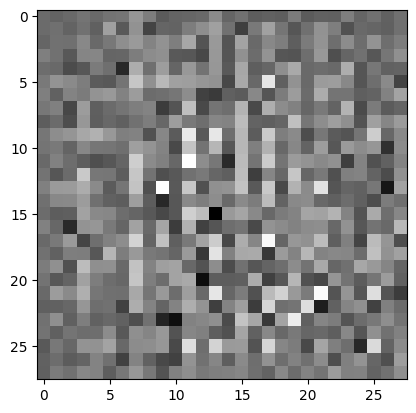

In [ ]:
generator = generator()
noise = tf.random.normal([1, 100])

# Image generate test
generated_image = generator(noise, training = False)
plt.imshow(generated_image[0, :,:,0], cmap='gray');

In [ ]:
def discriminator():
  """
  Create the discriminator model for WGAN-GP

  Returns:
      tf.keras.Sequential: A discriminator model with Layer Normalization.
  """
  network = tf.keras.Sequential()

  # 14x14x64
  network.add(layers.Conv2D(filters = 64, strides = (2,2), kernel_size = (5,5), padding = 'same', input_shape = [28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.LayerNormalization()) # Add Layer Normalization
  network.add(layers.Dropout(0.3))

  # 7x7x128
  network.add(layers.Conv2D(filters = 128, strides = (2,2), kernel_size = (5,5), padding = 'same'))
  network.add(layers.LeakyReLU())
  network.add(layers.LayerNormalization())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
# Discriminator
discriminator = discriminator()

# Discriminator test
discriminator(generated_image, training = False) # logits
# numpy=array([[-0.00030457]] -> 진짜도 가짜도 아닌 애매한 상태
tf.sigmoid(-0.00030457)
# numpy=0.49992383 (49.9%) -> 0: fake, 1: real

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_10 (LeakyReLU)           │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_11 (LeakyReLU)           │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

<tf.Tensor: shape=(), dtype=float32, numpy=0.49992382526397705>

In [ ]:
def loss_generator(fake_output):
  """
  Computes the loss for the generator

  Args:
     fake_output(Tensor): The discriminator's output for generated images.

  Returns:
      Tensor: Generator loss value.

  Example:
      loss = loss_generator(fake_output)
  """
  g_loss = -1. * tf.math.reduce_mean(fake_output)
  return g_loss

# Goal to minimize loss -> Generator
def loss_discriminator(real_output, fake_output, gradient_penalty):
  """
  Computes the loss for the discriminator using WGAN-GP.

  Args:
      real_output (Tensor): Discriminator output for real images.
      fake_output (Tensor): Discriminator output for generated images.
      gradient_penalty (Tensor): Gradient penalty term for improved training stability.

  Returns:
      Tensor: Discriminator loss value.

  Example:
      loss = loss_discriminator(real_output, fake_output, gp)
  """
  c_lambda = 5 # Gradient penalty coefficient
  d_loss = tf.math.reduce_mean(fake_output) - tf.math.reduce_mean(real_output) + c_lambda * gradient_penalty
  return d_loss

In [ ]:
def gradient_penalty(real, fake, epsilon):
  """
  Computes the gradient penalty for WGAN-GP.

  Args:
      real (tf.Tensor): A batch of real images with shape (batch_size, 28, 28, 1).
      fake (tf.Tensor): A batch of fake images generated by the generator.
      epsilon (tf.Tensor): Random values for interpolation, shape (batch_size, 1, 1, 1).

  Example:
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(real_images, fake_images, epsilon)

  Returns:
      tf.Tensor: Gradient penalty loss (scalar).
  """

  interpolated_images = real * epsilon + fake * (1 - epsilon)

  # Define as epsilon how much each image will use
  with tf.GradientTape() as tape:
    tape.watch(interpolated_images)
    scores = discriminator(interpolated_images)

  # Use interpolated_images which is combined with real and fake data
  gradient = tape.gradient(scores, interpolated_images)[0]
  gradient_norm = tf.norm(gradient)
  gp = tf.math.reduce_mean((gradient_norm - 1)**2)
  return gp

generator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.0, beta_2 = 0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.0, beta_2 = 0.9)

In [ ]:
epochs = 50
noise_dim = 100
number_of_images = 16
seed = tf.random.normal([number_of_images, noise_dim])

# Define train function
def training_step(images):
  """
  Performs one training step for both the discriminator and generator.

  Args:
      images (tf.Tensor): A batch of real images with shape (batch_size, 28, 28, 1)

  Example:
      for img_batch in dataset:
        training_step(img_batch)
  Loss:
      - Discriminator minimizes: D_loss = mean(fake_output) - mean(real_output) + o_lambda * gradient_penalty
      - Generator minimizes: G_loss = -mean(fake_output)
  """
  noise = tf.random.normal([batch_size, noise_dim])

  # Discriminator step
  # WGAN training number time: Generator < Discriminator
  discriminator_extra_steps = 5

  for i in range(discriminator_extra_steps):
    with tf.GradientTape() as d_tape:
      generated_images = generator(noise, training = True)
      real_output = discriminator(images, training = True)
      fake_output = discriminator(generated_images, training = True)
      epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
      gp = gradient_penalty(images, generated_images, epsilon)

      d_loss = loss_discriminator(real_output, fake_output, gp)
    discriminator_gradients = d_tape.gradient(d_loss, discriminator.trainable_variables)
    discriminator_optimizer.apply_gradients(zip(discriminator_gradients, discriminator.trainable_variables))

  # Train Discriminator
  with tf.GradientTape() as g_tape:
    generated_images = generator(noise, training = True)
    fake_output = discriminator(generated_images, training = True)
    g_loss = loss_generator(fake_output)
  generator_gradients = g_tape.gradient(g_loss, generator.trainable_variables)
  generator_optimizer.apply_gradients(zip(generator_gradients, generator.trainable_variables))

In [ ]:
def create_and_save_images(model, epoch, test_input):
    preds = model(test_input, training=False)
    fig = plt.figure(figsize=(4, 4))
    for i in range(preds.shape[0]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')
    plt.show()

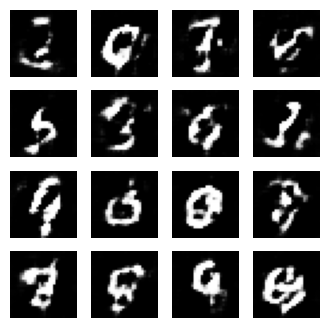

Epoch 1/50, Time: 201.17 sec
Generator Loss: -21.7825, Discriminator Loss: -5.0626


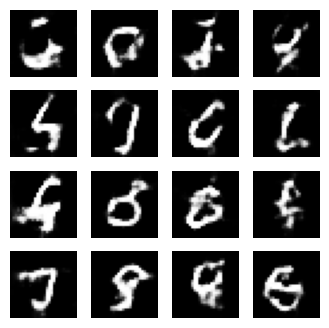

Epoch 2/50, Time: 196.14 sec
Generator Loss: -1.8272, Discriminator Loss: -1.8587


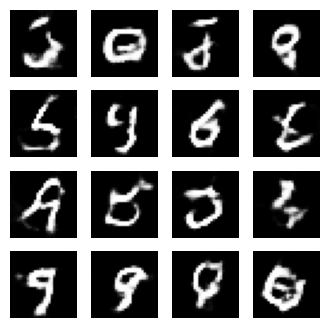

Epoch 3/50, Time: 198.52 sec
Generator Loss: -8.0843, Discriminator Loss: -1.0553


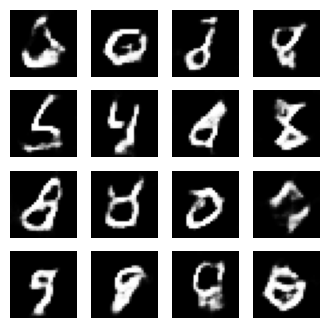

Epoch 4/50, Time: 198.01 sec
Generator Loss: -9.0148, Discriminator Loss: -0.9525


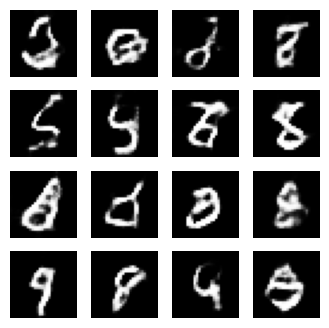

Epoch 5/50, Time: 202.13 sec
Generator Loss: -9.3173, Discriminator Loss: -0.9772


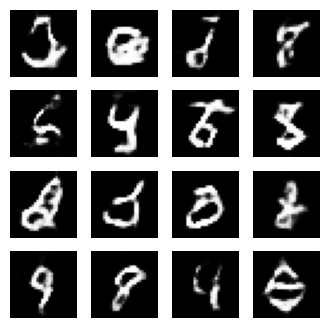

Epoch 6/50, Time: 199.06 sec
Generator Loss: -10.8547, Discriminator Loss: -1.0321


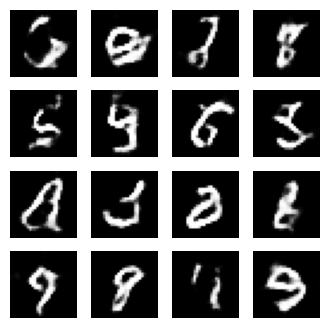

Epoch 7/50, Time: 200.49 sec
Generator Loss: -11.1999, Discriminator Loss: -1.0793


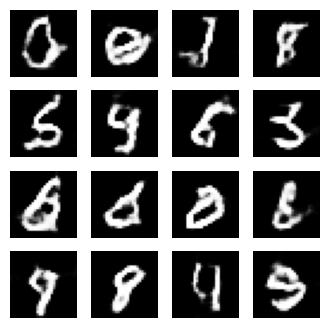

Epoch 8/50, Time: 197.28 sec
Generator Loss: -10.5886, Discriminator Loss: -1.0879


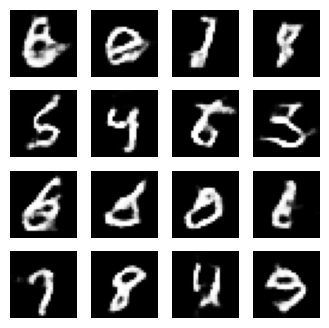

Epoch 9/50, Time: 199.05 sec
Generator Loss: -8.3605, Discriminator Loss: -1.1567


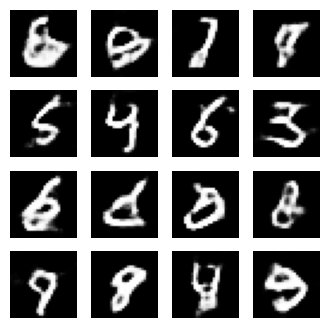

Epoch 10/50, Time: 196.79 sec
Generator Loss: -6.8001, Discriminator Loss: -1.0756


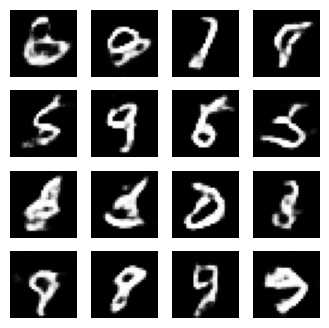

Epoch 11/50, Time: 196.22 sec
Generator Loss: -4.0146, Discriminator Loss: -1.0822


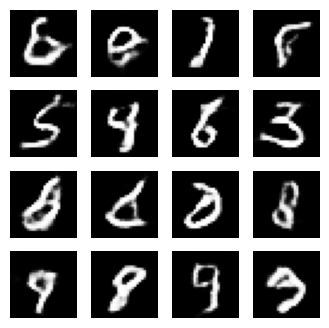

Epoch 12/50, Time: 196.89 sec
Generator Loss: -1.3095, Discriminator Loss: -1.0394


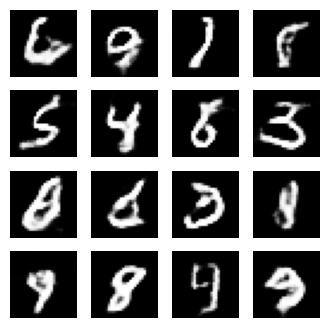

Epoch 13/50, Time: 196.05 sec
Generator Loss: 1.4239, Discriminator Loss: -1.0700


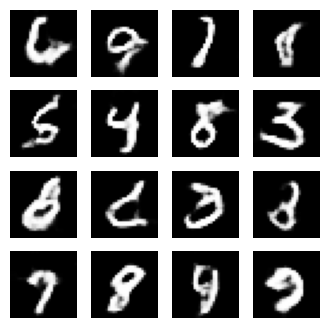

Epoch 14/50, Time: 202.13 sec
Generator Loss: 2.2944, Discriminator Loss: -1.0752


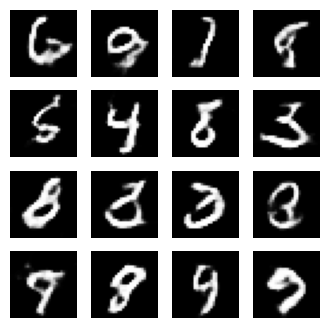

Epoch 15/50, Time: 202.54 sec
Generator Loss: 3.7380, Discriminator Loss: -1.0412


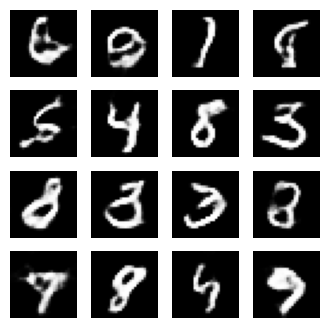

Epoch 16/50, Time: 193.10 sec
Generator Loss: 3.5953, Discriminator Loss: -1.0252


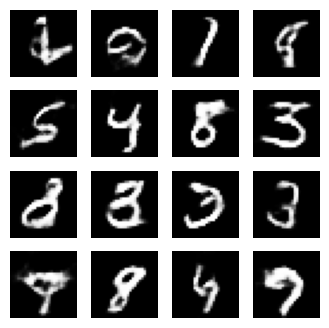

Epoch 17/50, Time: 193.09 sec
Generator Loss: 4.5456, Discriminator Loss: -0.9910


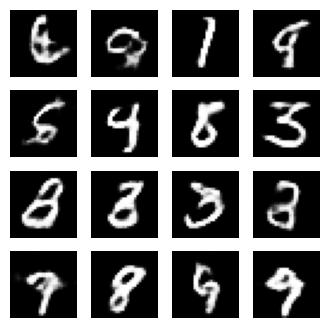

Epoch 18/50, Time: 196.19 sec
Generator Loss: 6.7669, Discriminator Loss: -1.0150


KeyboardInterrupt: 

In [ ]:
def train(dataset, epochs):
    """
    Trains the WGAN-GP model for a given number of epochs.

    Args:
        dataset (tf.data.Dataset): A dataset containing training images.
        epochs (int): Number of epochs to train.

    Example:
        train(X_train, epochs=50)

    Returns:
        None (saves generator model and generated images after training).
    """

    for epoch in range(epochs):
        start_time = time.time()
        g_losses, d_losses = [], []

        for img_batch in dataset:
            if len(img_batch) == batch_size:
                training_step(img_batch)

                # Calculate loss at each step
                noise = tf.random.normal([batch_size, noise_dim])
                generated_images = generator(noise, training=True)
                real_output = discriminator(img_batch, training=True)
                fake_output = discriminator(generated_images, training=True)
                epsilon = tf.random.normal([batch_size, 1, 1, 1], 0.0, 1.0)
                gp = gradient_penalty(img_batch, generated_images, epsilon)

                g_loss = loss_generator(fake_output)
                d_loss = loss_discriminator(real_output, fake_output, gp)

                g_losses.append(g_loss.numpy())
                d_losses.append(d_loss.numpy())

        # Save generated image
        create_and_save_images(generator, epoch + 1, seed)

        # Get loss value
        print(f'Epoch {epoch + 1}/{epochs}, Time: {time.time() - start_time:.2f} sec')
        print(f'Generator Loss: {tf.reduce_mean(g_losses):.4f}, Discriminator Loss: {tf.reduce_mean(d_losses):.4f}')

    # Save final generated image and model
    create_and_save_images(generator, epochs, seed)
    generator.save('generator.h5')

# Start Training
train(X_train, epochs)

# Generate final image
seed_input = tf.random.normal([number_of_images, noise_dim])
preds = generator(seed_input, training=False)
fig = plt.figure(figsize=(4, 4))
for i in range(preds.shape[0]):
    plt.subplot(4, 4, i + 1)
    plt.imshow(preds[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
    plt.axis('off')
plt.show()